<a href="https://colab.research.google.com/github/GenAIUnplugged/pytorch/blob/main/Pretrained_RestNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
from torchvision.models import resnet50,ResNet50_Weights
from torchvision import transforms
from torch.utils.data import random_split


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor()
])


train_ds = torchvision.datasets.OxfordIIITPet(
    root="./data",
    download=True,
    transform=transform,
    target_types='category'  # <== This is important
)


# 80% train, 20% test
train_size = int(0.8 * len(train_ds))
test_size = len(train_ds) - train_size
train_ds, test_ds = random_split(train_ds, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"


#Pre-trained models

model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False


class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn = nn.Sequential(
    nn.Linear(in_features=2048,out_features=64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=37))
  def forward(self,x):
    return self.nn(x)

model.fc = nn.Linear(in_features=model.fc.in_features, out_features=37)
model = model.to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs=10
model.train()
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    total_samples=0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch,(image,label) in enumerate(progress_bar):
        image,label = image.to(device),label.to(device)

        logits = model(image)
        loss = criterion(logits,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_probs = torch.softmax(input=logits, dim=1).argmax(dim=1)
        correct = (pred_probs==label).sum().item()
        total_correct+=correct
        total_loss += loss.item()
        total_samples += label.size(0)

    print(f"Epoch={epoch},Loss={total_loss/len(train_loader)},Accuracy={total_correct/total_samples}")

model.eval()
with torch.no_grad():
    total_loss = 0
    total_correct = 0
    total_samples=0
    progress_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch,(image,label) in enumerate(progress_bar):
        image,label = image.to(device),label.to(device)
        test_logits = model(image)
        test_loss = criterion(test_logits,label)
        pred_probs = torch.softmax(input=test_logits, dim=1).argmax(dim=1)
        correct = (pred_probs==label).sum().item()
        total_correct+=correct
        total_loss += test_loss.item()
        total_samples += label.size(0)

print(f"Epoch={epoch},Loss={total_loss/len(test_loader)},Accuracy={total_correct/total_samples}")

Epoch 1/10: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]


Epoch=0,Loss=3.1742614110310874,Accuracy=0.30264945652173914


Epoch 2/10: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]


Epoch=1,Loss=2.292815546194712,Accuracy=0.7758152173913043


Epoch 3/10: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]


Epoch=2,Loss=1.6432385444641113,Accuracy=0.9052309782608695


Epoch 4/10: 100%|██████████| 12/12 [00:31<00:00,  2.59s/it]


Epoch=3,Loss=1.194225162267685,Accuracy=0.9191576086956522


Epoch 5/10: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]


Epoch=4,Loss=0.8990636169910431,Accuracy=0.9368206521739131


Epoch 6/10: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]


Epoch=5,Loss=0.7044423768917719,Accuracy=0.9463315217391305


Epoch 7/10: 100%|██████████| 12/12 [00:31<00:00,  2.59s/it]


Epoch=6,Loss=0.5687980875372887,Accuracy=0.9521059782608695


Epoch 8/10: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]


Epoch=7,Loss=0.4884035388628642,Accuracy=0.9541440217391305


Epoch 9/10: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]


Epoch=8,Loss=0.42016151547431946,Accuracy=0.9636548913043478


Epoch 10/10: 100%|██████████| 12/12 [00:31<00:00,  2.58s/it]


Epoch=9,Loss=0.37259874244530994,Accuracy=0.9612771739130435


Epoch 10/10: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]

Epoch=9,Loss=0.5638743241628011,Accuracy=0.8872282608695652


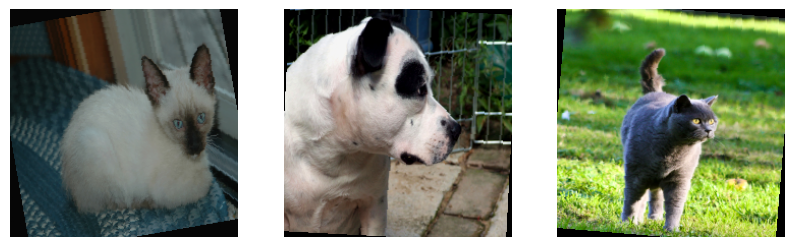

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
image,label = next(iter(train_loader))

# Determine the number of images to display (e.g., the first 3)
num_images_to_display = 3

# Loop through the first 'num_images_to_display' images
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1) # Create subplot
    plt.imshow(image[i].permute(1, 2, 0)) # Display the i-th image
    plt.axis('off') # Turn off axis for the current subplot

plt.show()